In [1]:
import sys
import model as model
import visualization as visualization
import evaluate as evaluate
import helper_functions as hf

import numpy as np

In [2]:
images_20, timestamp_20 = hf.load_images_from_folder('data/images/dia_20',cutUruguay = True)

In [3]:
predictions, predict_ts = model.persitence(images_20[80], timestamp_20[80], 5)
print(len(predictions))
print(timestamp_20[80])
print(predict_ts)

5
2020-01-20 13:20:17
DatetimeIndex(['2020-01-20 13:30:17', '2020-01-20 13:40:17',
               '2020-01-20 13:50:17', '2020-01-20 14:00:17',
               '2020-01-20 14:10:17'],
              dtype='datetime64[ns]', freq='10T')


In [4]:
predict_itself = evaluate.evaluate_image(predictions[0], images_20[80], metric='PSNR',  pixel_max_value =255) 
predict_errors = evaluate.evaluate_image(predictions, images_20[81:86], metric='PSNR',  pixel_max_value =255)
print(predict_itself)
print(predict_errors)

[48.1308036086791]
[30.093210758088773, 29.36784066722156, 28.889517150612193, 28.87933856142093, 28.7765109036826]


In [5]:
predict_horizon = 10
error_p_list =[]
error_gp_list =[]

for i in range(len(images_20)-predict_horizon):
    if (i < len(images_20)-predict_horizon):
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], predict_horizon)
        predictions_gp, _ = model.gauss_persitence(images_20[i], timestamp_20[i], predict_horizon,sigma=30)
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:i+predict_horizon+1], 
                                                metric='RMSE',  pixel_max_value =255)
        predict_errors_gp = evaluate.evaluate_image(predictions_gp, images_20[i+1:i+predict_horizon+1], 
                                                metric='RMSE',  pixel_max_value =255)
        error_p_list.append(predict_errors_p)
        error_gp_list.append(predict_errors_gp)
    
print('Predicted for',len(error_p_list), 'images')
print(len(error_p_list[0]))

error_p_array = np.array(error_p_list)
error_gp_array = np.array(error_gp_list)

print(error_p_array.shape)
    

Predicted for 134 images
10
(134, 10)


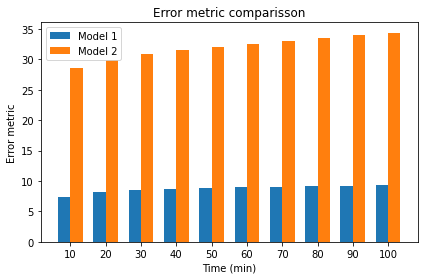

In [6]:
mean_error_p = np.mean(error_p_array[70:100],axis=0)
mean_error_gp = np.mean(error_gp_array[70:100],axis=0)


visualization.barchart_compare(mean_error_p,mean_error_gp)

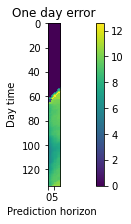

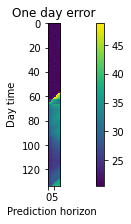

In [7]:
visualization.matrix_graph(error_p_array)
visualization.matrix_graph(error_gp_array)

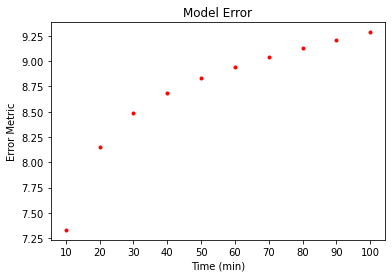

In [8]:
visualization.plot_graph(mean_error_p)